In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
   # for filename in filenames:
      #  print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Experimenting with Kaggle


In [6]:
#### Loading and unzipping training data

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from pathlib import Path
import os
import numpy as np
from functools import partial
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [8]:
!pwd


/kaggle/working


In [9]:
!ls
!ls -al
!ls -al .virtual_documents/

total 12
drwxr-xr-x 3 root root 4096 May 20 09:58 .
drwxr-xr-x 5 root root 4096 May 20 09:58 ..
drwxr-xr-x 2 root root 4096 May 20 09:58 .virtual_documents
total 8
drwxr-xr-x 2 root root 4096 May 20 09:58 .
drwxr-xr-x 3 root root 4096 May 20 09:58 ..


In [10]:
!ls /

'=2023.0.1'				    libx32
 NGC-DL-CONTAINER-LICENSE		    media
 bin					    mnt
 boot					    opt
 dev					    proc
 entrypoint.sh				    root
 etc					    run
 home					    run_jupyter.sh
 install_packages.sh			    sbin
 kaggle					    srv
 lib					    sys
 lib32					    tmp
 lib64					    usr
 libnvinfer8_8.6.1.6-1+cuda12.0_amd64.deb   var


In [11]:
!ls ..

input  lib  working


In [12]:
!ls ../input

dogs-vs-cats-small-test  dogs-vs-cats-small-train  dogs-vs-cats-small-val


In [13]:
!ls ../input/dogs-vs-cats-small-test/dogs_vs_cats_small_test

cats  dogs


In [14]:
train_path = "/kaggle/input/dogs-vs-cats-small-train/dogs_vs_cats_small_train"
val_path = "/kaggle/input/dogs-vs-cats-small-val/dogs_vs_cats_small_val"
test_path = "../kaggle/input/dogs-vs-cats-small-test/dogs-vs-cats-small-test"

if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
    train_path = Path().absolute().parent / "input" / "dogs-vs-cats-small-train/dogs_vs_cats_small_train"
    val_path = Path().absolute().parent / "input" / "dogs-vs-cats-small-val/dogs_vs_cats_small_val"
    test_path = Path().absolute().parent / "input" / "dogs-vs-cats-small-test/dogs_vs_cats_small_test"

train_path

PosixPath('/kaggle/input/dogs-vs-cats-small-train/dogs_vs_cats_small_train')

In [15]:
sample_image = plt.imread(train_path / "dogs" / "dog.5226.jpg")
sample_image.shape

(486, 499, 3)

In [ ]:
plt.imshow(sample_image)

### a) Använd följande nätverk och träna på datan. Gör hyperparametertuning för några parametrar (beskriv hur du gör). Visualisera och analysera loss-kurvor, accuracy-kurvor.


load and preprocess the data

In [17]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [18]:
print(train_generator.class_indices)

{'cats': 0, 'dogs': 1}


In [19]:
print(test_generator.class_indices)

{'cats': 0, 'dogs': 1}


In [20]:
def extract_data(generator):
    images, labels = [], []
    for _ in range(len(generator)):
        img, lbl = next(generator)
        images.extend(img)
        labels.extend(lbl)
    return np.array(images), np.array(labels)

# train and validation data
X_train, y_train = extract_data(train_generator)
X_val, y_val = extract_data(val_generator)

Desired architecture for the network:

Conv2d (size: (3x3), kernels:32, activation: ReLU) -> Maxpooling(stride: (2,2), size: (2x2) -> 
Conv2d (size: (3x3), kernels:64, activation: ReLU) -> Maxpooling(stride: (2,2), size: (2x2) -> 
Conv2d (size: (3x3), kernels:128, activation: ReLU) -> Maxpooling(stride: (2,2), size: (2x2) -> 
Conv2d (size: (3x3), kernels:128, activation: ReLU) -> Maxpooling(stride: (2,2), size: (2x2) -> 
Flatten (activation: ReLU) -> Dropout (rate:0.3) -> Fully connected (nodes: 512, activation: ReLU) -> 
Output: (nodes: 1, activation: sigmoid)


In [21]:
def create_model(learning_rate=0.01, dropout_rate=0.3):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dropout(dropout_rate),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

Hyperparameter Tuning:

In [22]:
param_grid = {
    'model__learning_rate': [0.001, 0.01, 0.1],
    'model__dropout_rate': [0.3, 0.5, 0.7]
}

# Create a wrapper for the Keras model with partial function
wrapped_model = KerasClassifier(model=partial(create_model), epochs=5, batch_size=batch_size, verbose=0)

# Perform Grid Search (adjust cv value for more folds)
grid_search = GridSearchCV(estimator=wrapped_model, param_grid=param_grid, cv=3)

# Fit the Grid Search
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print details of the best model
print(f"Best Learning Rate: {best_params['model__learning_rate']}")
print(f"Best Dropout Rate: {best_params['model__dropout_rate']}")

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
I0000 00:00:1716199275.711727     157 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716199275.731021     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716199280.895857     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
W0000 00:0

Best Learning Rate: 0.001
Best Dropout Rate: 0.7


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
W0000 00:00:1716199603.920382     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716199605.840160     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716199607.266307     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


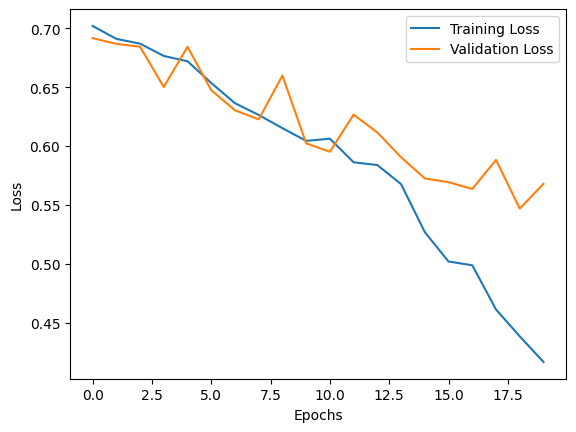

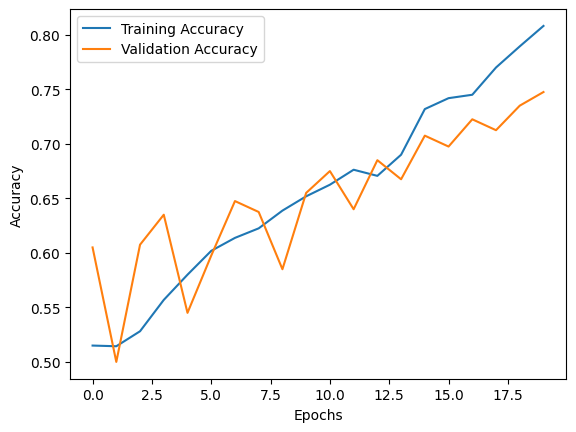

In [23]:
# Train the best model on the full training data and validate on validation data
best_model.set_params(epochs=20)
best_model.fit(X_train, y_train, validation_data=(X_val, y_val))

# Visualize and analyze loss curves, and accuracy curves
history = best_model.model_.history

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
# Combine train and validation data
X_combined = np.concatenate((X_train, X_val), axis=0)
y_combined = np.concatenate((y_train, y_val), axis=0)

In [25]:
# Train the best model on the combined training and validation data
best_model.set_params(epochs=20)
best_model.fit(X_combined, y_combined)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
W0000 00:00:1716199635.578634     155 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716199640.869582     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


KerasClassifier(
	model=functools.partial(<function create_model at 0x7923b53dc0d0>)
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=20
	class_weight=None
	model__dropout_rate=0.7
	model__learning_rate=0.001
)

In [26]:
# Initialize variables
num_images_to_test = 100
y_pred_prob_list = []
y_test_list = []

# Reset the test generator to start from the beginning
test_generator.reset()

# Perform inference on a subset of the test data
for i in range(num_images_to_test):
    # Generate batch of test data
    X_batch, y_batch = next(test_generator)
    
    # Predict probabilities for the current batch
    y_pred_prob_batch = best_model.predict(X_batch)
    y_pred_prob_list.append(y_pred_prob_batch)
    
    # Append true labels for the current batch
    y_test_list.append(y_batch)

# Concatenate predictions and true labels from all batches
y_pred_prob = np.concatenate(y_pred_prob_list)
y_test = np.concatenate(y_test_list)

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.78      0.88       100
         1.0       0.00      0.00      0.00         0

    accuracy                           0.78       100
   macro avg       0.50      0.39      0.44       100
weighted avg       1.00      0.78      0.88       100

Confusion Matrix:
[[78 22]
 [ 0  0]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[78 22]
 [ 0  0]]


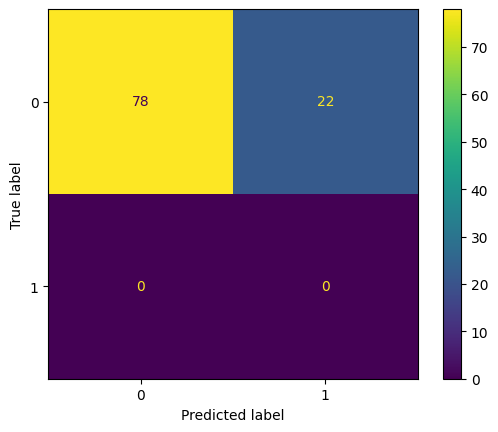

In [35]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()